<a href="https://www.kaggle.com/code/hoshimmardonov1/hierarchical-clustering?scriptVersionId=125590385" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib import pylab 
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import scipy
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix  
from scipy.cluster.hierarchy import fcluster
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 

Dataset

In [2]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/cars_clus.csv"
df = pd.read_csv(url)
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


In [3]:
df[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = df[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df = df.reset_index(drop=True)
df.head(5)

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


In [4]:
featureset = df[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']]

In [5]:
x = featureset.values #numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx[0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       ],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333]])

In [6]:
leng = feature_mtx.shape[0]
D = np.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])
D

array([[0.        , 0.57777143, 0.75455727, ..., 0.28530295, 0.24917241,
        0.18879995],
       [0.57777143, 0.        , 0.22798938, ..., 0.36087756, 0.66346677,
        0.62201282],
       [0.75455727, 0.22798938, 0.        , ..., 0.51727787, 0.81786095,
        0.77930119],
       ...,
       [0.28530295, 0.36087756, 0.51727787, ..., 0.        , 0.41797928,
        0.35720492],
       [0.24917241, 0.66346677, 0.81786095, ..., 0.41797928, 0.        ,
        0.15212198],
       [0.18879995, 0.62201282, 0.77930119, ..., 0.35720492, 0.15212198,
        0.        ]])

In [7]:
Z = hierarchy.linkage(D)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


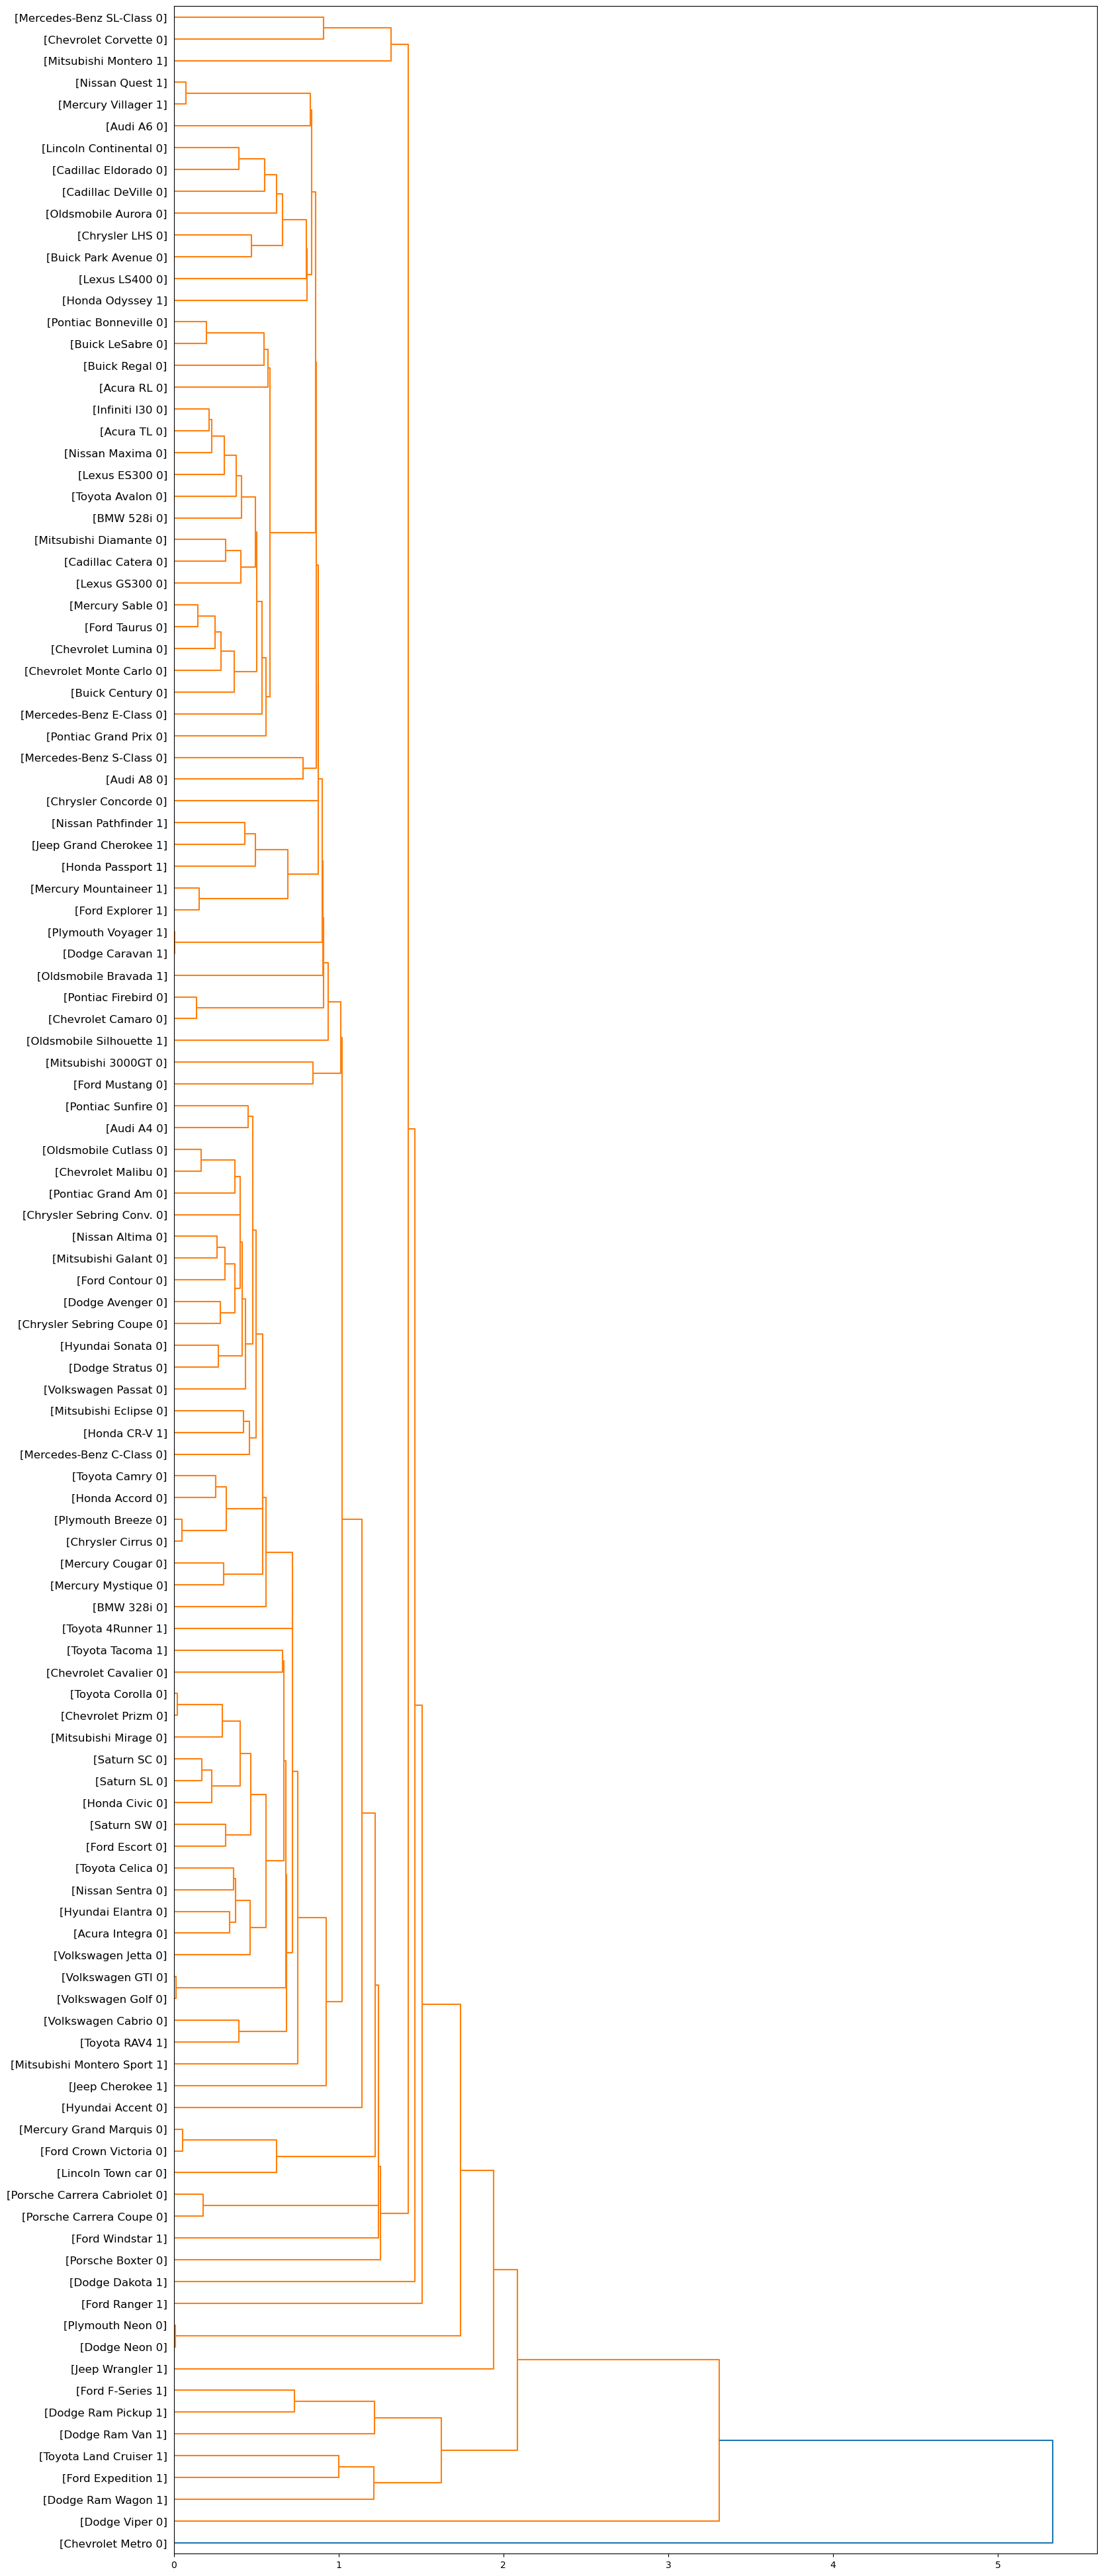

In [8]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (df['manufact'][id], df['model'][id], int(float(df['type'][id])) )
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

In [9]:
k = 5 # 5 ta klaster
clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       5, 2, 2, 2, 2, 2, 2, 2, 2, 4, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2], dtype=int32)

In [10]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(feature_mtx)

agglom.labels_

array([1, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 1, 2, 2, 2, 5, 1,
       4, 1, 1, 2, 1, 2, 1, 1, 1, 5, 0, 0, 0, 3, 2, 1, 2, 1, 2, 3, 2, 3,
       0, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 2, 2, 2, 3, 3, 3, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 2, 3, 2, 3, 1, 2, 3, 5, 1, 1, 2, 3, 2, 1, 3,
       2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1])

In [11]:
df['cluster'] = agglom.labels_
agg_cars = df.groupby(['cluster','type'])['horsepow','engine_s','mpg','price'].mean()
agg_cars

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


horsepow  engine_s        mpg      price
cluster type                                            
0       1.0   211.666667  4.483333  16.166667  29.024667
1       0.0   146.531915  2.246809  27.021277  20.306128
        1.0   145.000000  2.580000  22.200000  17.009200
2       0.0   203.111111  3.303704  24.214815  27.750593
        1.0   182.090909  3.345455  20.181818  26.265364
3       0.0   256.500000  4.410000  21.500000  42.870400
        1.0   160.571429  3.071429  21.428571  21.527714
4       0.0    55.000000  1.000000  45.000000   9.235000
5       0.0   365.666667  6.233333  19.333333  66.010000